# Multi Greek Hedging

In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from utils.process import process_options,process_underlying,process_rf
from utils.greeks import delta, gamma, vega, theta, rho
from utils.implied_volatility import implied_vol_b76,plot_vol_surface,fill_missing_iv, price_future_option
from tqdm import tqdm

tqdm.pandas()

all_options = pd.read_csv('../data/SPYOPT_processed.csv',index_col=0, parse_dates=['ts_event', 'expiration_date',])
risk_free_rate = pd.read_csv('../data/RFRate.csv',index_col=0, parse_dates=['ts_event'])
futures = pd.read_csv('../data/SPYFUT_processed.csv',index_col=0, parse_dates=['ts_event'])


### Setup:

In this portfolio, the goal is to hedge not just the delta, but also gamma and vega, assuring that the portfolio is as stable as possible. In this case, the following option was chosen for completeness:

**Option Strike**: 5400

**Option Type**: Call

**Option Expiration Date**: 2024-06-21

Our period of interest, especially regarding the data, is the time the option was initially traded until its expiration date. 

**Start time**: 2023-05-29

**End time**: 2024-06-21

For interpolation purposes, the futures value with the next and previous maturation date as been determined as well.




In [3]:
option_strike = 5400
option_type = 'C'
option_exp_date = '2024-06-21'

start_time = '2023-05-29'
end_time = '2024-06-21'

future_u = '2024-09-20'
future_l = '2024-03-15'

## Data Preparation

### 1. Filtering by Time

First, we want to filter all the option values to be included in this time frame, filtering between start and end time. Secondly, we want to focus our efforts on call options only. 

To make sure we only have the relevant date, we choose the closing values as our option values for a given date, and drop all the other irrelevant ones.

In [4]:
all_options = all_options[(all_options.index >= start_time ) & (all_options.index <= end_time)] # get only relevant ones for our time frame
all_calls = all_options[all_options['option_type'] == 'C'] # Only calls

all_calls['V'] = all_calls['close'] # Use close price as value
all_calls = all_calls.drop(columns=['open', 'high', 'low','close', 'volume']) # remove rest
all_calls = all_calls.reset_index()


/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_58650/3136317990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_calls['V'] = all_calls['close'] # Use close price as value


We want to make sure that we have all of the dates in our dataset, and therefore make our own index.

In [5]:
datetime_index = pd.date_range(start=start_time, end=end_time, freq="B")
options = (
    all_calls
    .reset_index()[['option_type','strike','expiration_date']]
    .drop_duplicates()
)

### 2. Adding the risk free rate $r$

The next step is to make sure that the risk free rate (1 Month bonds) is available on each of the dates. Secondly we need to make sure that the rate is annualized for the calculations of the implied volatility and the greeks.

We do this by doing the following:

original rate = $1.04$
annualized rate = $ 12*\log(1+\frac{1.04}{100})$


In [6]:
rf_rate = risk_free_rate.reindex(pd.date_range(start=pd.to_datetime(start_time)-pd.Timedelta(weeks=1),end=end_time), method='ffill').ffill().reindex(datetime_index, method='ffill')
rf_rate.index = pd.to_datetime(rf_rate.index)

rf_rate['rate'] = rf_rate['rate']/100
rf_rate['rate'] = 12* np.log(1 + rf_rate['rate'])  # Convert to annualized rate

Similar to before we want every option to be available on every date for optimal hedging.

In [7]:
tuples = []
for _, opt in options.iterrows():
    # pick only the times up to (and including) expiry
    valid_ts = datetime_index[datetime_index <= opt.expiration_date]
    for ts in valid_ts:
        tuples.append((ts, opt.option_type, opt.strike, opt.expiration_date))

mi = pd.MultiIndex.from_tuples(
    tuples,
    names=['ts_event','option_type','strike','expiration_date']
)

all_calls_every_day = (
    all_calls
    .reset_index()
    .set_index(['ts_event','option_type','strike','expiration_date'])
    .reindex(mi)
    .sort_index()
    .reset_index()
) .drop(columns=['index','V'])

Putting it all together, adding the option information to our empty dataframe and adding the risk free rate as well.

In [8]:
all_calls_every_day = all_calls_every_day.merge(
    all_calls[['ts_event','option_type','strike','expiration_date','V']],
    on=['ts_event','option_type','strike','expiration_date'],
    how='left',
    suffixes=('', '_last')
)
all_calls_every_day['r'] = all_calls_every_day['ts_event'].map(
    rf_rate['rate']
)

### 3. Adding the time till expiry $T$ and Futures value $F$

Here we are adding the risk free rate $r$, the time until expiry $T$ (in years, where 1 is one year) and the corresponding futures value of the future with same expiration date as the option on the given date.

In [9]:
all_calls_every_day['T'] = (all_calls_every_day['expiration_date'] - all_calls_every_day['ts_event']).dt.days/365

futures_upper = futures[futures['expiration_date'] == future_u]
futurse_upper = futures_upper.sort_values('ts_event')
futures_lower = futures[futures['expiration_date'] == future_l]
futures_lower = futures_lower.sort_values('ts_event').reset_index().set_index('ts_event')
futures_upper.index = pd.to_datetime(futures_upper.index)
futures_lower.index = pd.to_datetime(futures_lower.index)
futures = futures.reset_index()
futures['expiration_date'] = pd.to_datetime(futures['expiration_date'])
all_calls_every_day = all_calls_every_day.merge(
    futures[['ts_event','expiration_date','close']]
           .rename(columns={'close':'F'}),
    on=['ts_event','expiration_date'],
    how='left'
)

### 4. Filling Missing Data

#### Missing Futures

Since not every futures value is found on every given day, it is oftten tough to have the proper data to hedge. To do this, we will interpolate using the values available on the given day with expiries before and after and then weigh them by their $T$. If neither are available we will forward fill until no futures values are missing.


In [10]:
missing_futures_rows = all_calls_every_day[all_calls_every_day['F'].isna()]
missing_futures_dates = pd.to_datetime(missing_futures_rows['ts_event'].unique())

for date in missing_futures_dates:
    upper_t = (pd.to_datetime(future_u) - date).days / 365
    lower_t = (pd.to_datetime(future_l) - date).days / 365
    main_t = (pd.to_datetime(option_exp_date) - date).days / 365

    if date in futures_upper.index and date in futures_lower.index:
        upper_value = futures_upper.loc[date, 'close']
        lower_value = futures_lower.loc[date, 'close']

        all_calls_every_day.loc[
            (all_calls_every_day['ts_event'] == date),
            'F'
        ] = (upper_t-main_t)/(upper_t-lower_t) * upper_value + (main_t-lower_t)/(upper_t-lower_t) * lower_value

all_calls_every_day['F'] = all_calls_every_day['F'].ffill()


#### Missing Options Values 

Similar to before, not every Option is available on every given date. Given the implied volatility (IV), its strike, time until expiration and futures value, we can use Black Sholes or its more advanced Black-76 equation, to solve for the option value V.

Before making this determination, we first filter for all relevant options, more specifically, all options that have been traded on 30 or more days. This assures that most of the options that are traded way before their expiration (1.5+ years) or with completely absurd strike prices are filtered out.

In [11]:
all_calls_every_day_filtered = (
        all_calls_every_day
        .groupby([ 'option_type', 'strike', 'expiration_date'])
        .filter(lambda grp: grp['V'].notna().sum() > 30)
    )

For the options that are have the values at a given time point, we can calculate the implied volatility IV. Since not every option has a value on a given day, we can construct the value by creating the volatility surface on a given day and then sampling from there.
After that we can determine the value as we do before.

In [12]:
all_calls_every_day_filtered['IV'] = all_calls_every_day_filtered.progress_apply(
    lambda row: implied_vol_b76(
        row['F'],
        row['strike'],
        row['T'],
        row['r'],
        row['V'],
    ),
    axis=1
)

def grouper1(group):
    ts_event = group['ts_event'].iloc[0]
    return fill_missing_iv(group)

all_calls_every_day_filtered = all_calls_every_day_filtered.groupby(
    by=['ts_event']).progress_apply(grouper1).reset_index(drop=True)

 38%|███▊      | 30265/80480 [00:05<00:09, 5113.68it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
100%|█████████▉| 279/280 [00:14<00:00, 42.05it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 280/280 [00:15<00:00, 18.65it/s]


Since we do not want to include all of the options that are very volatile due to their upcoming expiration, we filter out for those. 

(There was also an issue with the specific date 2024-03-29, which is why it has also been excluded.)

In [13]:
all_calls_every_day_filtered = all_calls_every_day_filtered[(all_calls_every_day_filtered['T'] > 0.0192) | ((all_calls_every_day_filtered['expiration_date'] == pd.to_datetime(option_exp_date)) &  (all_calls_every_day_filtered['option_type'] == option_type) & (all_calls_every_day_filtered['strike'] == option_strike))  ]
all_calls_every_day_filtered = all_calls_every_day_filtered[all_calls_every_day_filtered['ts_event'] != '2024-03-29']

Here we price the option:

In [14]:
def applier(row):
    if pd.isna(row['V']):
        row['V'] = price_future_option(
            row['F'],
            row['strike'],
            row['T'],
            row['IV'],
            row['r'],
            option_type=row['option_type']
        )    
        return row
    else:
        return row
    
all_calls_every_day_filtered = all_calls_every_day_filtered.apply(applier, axis=1) 

### 5. Calculating the Greeks

The last step is to calculate the greeks. Since we are going to be hedging against delta, gamma and vega (first and second order price changes and volatility), we are going to be calcualting those.

In [15]:
all_calls_every_day_filtered['delta'] = all_calls_every_day_filtered.progress_apply(
    lambda row: delta(
        row['F'],
        row['strike'],
        row['T'],
        row['IV'],
        row['r'],
    ),
    axis=1
)
all_calls_every_day_filtered['gamma'] = all_calls_every_day_filtered.progress_apply(
    lambda row: gamma(
        row['F'],
        row['strike'],
        row['T'],
        row['IV'],
        row['r'],
    ),
    axis=1
)
all_calls_every_day_filtered['vega'] = all_calls_every_day_filtered.progress_apply(
    lambda row: vega(
        row['F'],
        row['strike'],
        row['T'],
        row['IV'],
        row['r'],
    ),     
    axis=1
)

# There were some issues with gamma being NaN, so we fill those with 0. These were on expiration dates where the gamma is not defined.
all_calls_every_day_filtered['gamma'] = all_calls_every_day_filtered['gamma'].fillna(0)

 97%|█████████▋| 76290/78431 [00:02<00:00, 30649.37it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
100%|█████████▉| 78241/78431 [00:02<00:00, 29519.48it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-r * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
 98%|█████████▊| 76647/78431 [00:02<00:00, 29851.04it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) 

### 6. Save the data

In [16]:
all_calls_every_day_filtered.to_csv('../results/FullDataset.csv')

# Rollout

In [17]:
data = pd.read_csv('../results/FullDataset.csv', index_col=0, parse_dates=['ts_event', 'expiration_date'])

### Hedging Function

The following is the core part of the multi greek hedging. At each time step *ts_event*, we are going to be rebalancing the portfolio. The following function *hedge* does all of the calculations.

1. Select the option value and its corresponding greeks.
2. Select the corresponding Futures value. (keep in mind that this has a $\Delta = 1, \Gamma = 0, \mu =0$)
3. Select the other options and its correspnding greeks.

After doing so we have all the neccessary information to hedge the portfolio. The next and crucial step is to find the weights of the other options such that the portfolio is neutral. Since we can use the future to balance out all delta, we will optimize the weights so that the $\Gamma$ and $\mu$ are neutralized.

There are two ways that are implemented here, with different benefits.

1. Linear Programming: The way the linear program is defined minimizes the amount of options positions that you take. The resulting weights are largely 0 with few non zero entries at the downside of maybe not ideally neutralized the exposures.

2. Pseudo Inverse: This method minimizes the squared error. It will (from experience), neutralize the exposures better at the downside of taking many more positions (fractional positions in each option)

After calculating the weights, we can calculate the remaining delta and such our futures position. We can then also calculate the total value invested in the other options of the portfolio, the total portfolio value and the total portfolio greek exposure (which should be zero at all times.)

In [18]:
from scipy.optimize import linprog

def hedge(group,mode='pinv'):

    #Target Option
    main_value = group[(group['strike'] == option_strike) & (group['option_type'] == option_type) & (group['expiration_date'] == option_exp_date)]['V'].to_numpy()
    main_greeks = group[(group['strike'] == option_strike) & (group['option_type'] == option_type) & (group['expiration_date'] == option_exp_date)][['delta', 'gamma', 'vega']]
    main_greeks_np =  main_greeks.to_numpy().T
    main_gv = main_greeks_np[1:]

    # Underlying Future
    futures_value =  group[(group['strike'] == option_strike) & (group['option_type'] == option_type) & (group['expiration_date'] == option_exp_date)]['F'].to_numpy()

    # Other Options
    options_greeks = group[~((group['strike'] == option_strike) & (group['option_type'] == option_type) & (group['expiration_date'] == option_exp_date))][['delta', 'gamma', 'vega']].to_numpy().T
    total_gv = options_greeks[1:]  # Exclude the first row (which is the futures weight)
    total_dgv = options_greeks

    if mode == 'linprog':
        n = total_gv.shape[1]                         

        c     = np.ones(2 * n)                            
        A_eq  = np.hstack(( total_gv, -total_gv)) 
        b_eq  = - main_gv.flatten()
        bounds = [(0, None)] * (2 * n)                    

        res = linprog(c, A_eq=A_eq, b_eq=b_eq,
                    bounds=bounds, method='highs')

        if res.success:
            p, n = res.x[:n], res.x[n:]
            hedge_weights = p - n                         
        else:
            hedge_weights = np.zeros(n)
    else:
        hedge_weights = np.linalg.pinv(total_gv).dot(-main_gv).squeeze()               

    hedge_values = group[~((group['strike'] == option_strike) & (group['option_type'] == option_type) & (group['expiration_date'] == option_exp_date))]['V'].to_numpy()    
    hedge_total_value = np.dot(hedge_weights, hedge_values)
    hedge_greeks = np.dot(hedge_weights, total_dgv.T)

    remaining_delta = main_greeks_np[0] + np.dot(hedge_weights, total_dgv[0]) 
    all_options_total_greeks = hedge_greeks + main_greeks_np.squeeze()

    result = {'main_option_value': main_value , 
              'main_option_greeks': main_greeks_np,
              #'portfolio_option_weights':hedge_weights,
              'other_options_total_value':hedge_total_value,
              'other_options_total_greeks':hedge_greeks, 
              'all_options_total_greeks': all_options_total_greeks,

              'remaining_delta': remaining_delta,

              'future_value': futures_value,
              'futures_position':-remaining_delta*futures_value ,
              
              'total_portfolio_value': main_value+hedge_total_value-remaining_delta*futures_value 
              }
    

    return pd.Series(result) 

results = data.groupby('ts_event').progress_apply(hedge)


 93%|█████████▎| 259/279 [00:00<00:00, 863.20it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 279/279 [00:00<00:00, 844.94it/s]


### Postprocessing:

After dropping all NaN rows (there shouldn't be any). We then postprocess the data from the groupby operation. Since a lot of them are returned as arrays, we need to extract them into separate lists and modify them into dataframes.

In [19]:
results = results.dropna()
results.to_csv('../results/Results.csv')

In [20]:
greeks_option = pd.DataFrame(
    [ [x[0] for x in entry] for entry in results['main_option_greeks'] ],
    index=results['main_option_greeks'].index,
    columns=['delta', 'gamma', 'vega']
).iloc[:-1]

other_options_greeks = pd.DataFrame(
    [entry for entry in results['other_options_total_greeks'] ],
    index=results['other_options_total_greeks'].index,
    columns=['delta', 'gamma', 'vega']
).iloc[:-1]

portfolio_greeks = pd.DataFrame(
    [ entry for entry in results['all_options_total_greeks'] ],
    index=results['all_options_total_greeks'].index,
    columns=['delta', 'gamma', 'vega']
).iloc[:-1]

## Results

As you can see, the options position hovers closesly around zero, and is hedged against the greeks for most of the portfolio time. At the end close to expiration of the main option, when gamma explodes, the hedging becomes slighlty unstable and causes the positions to skyrocket.

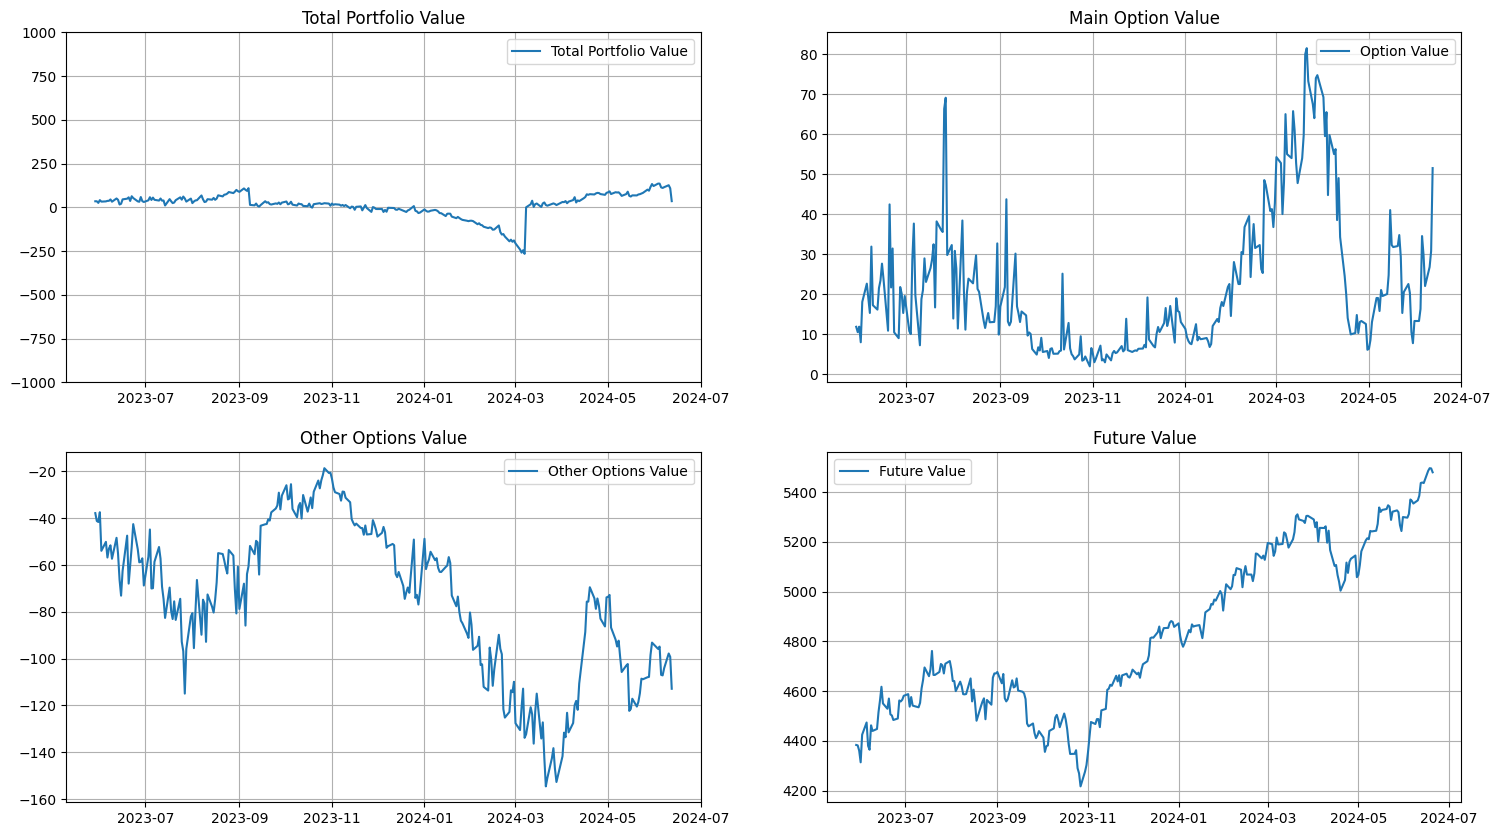

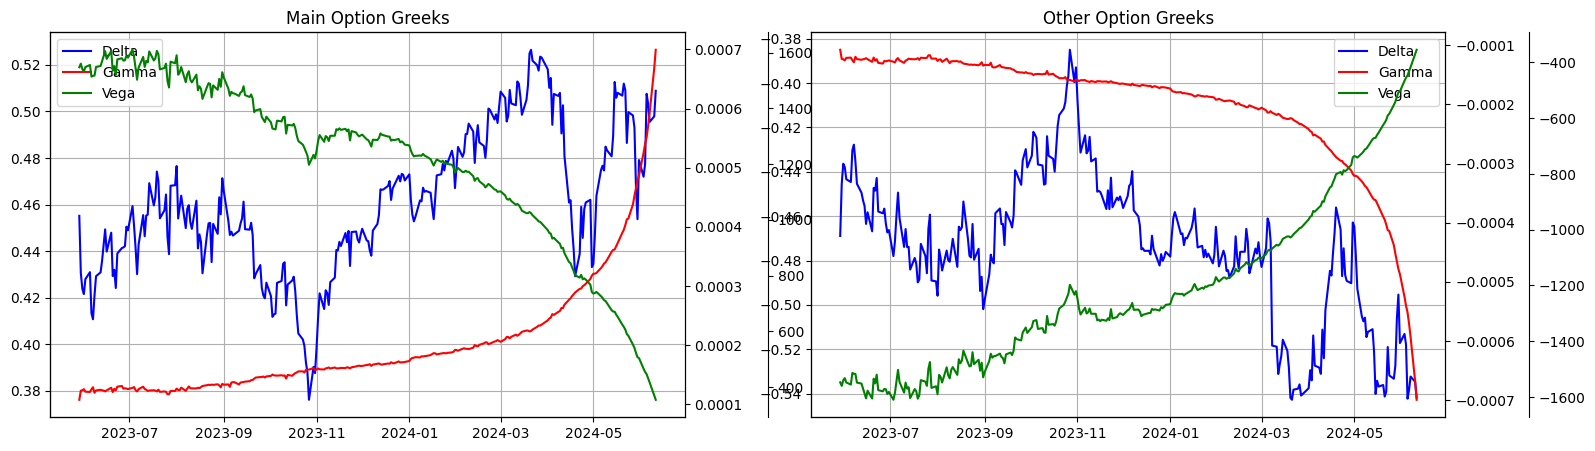

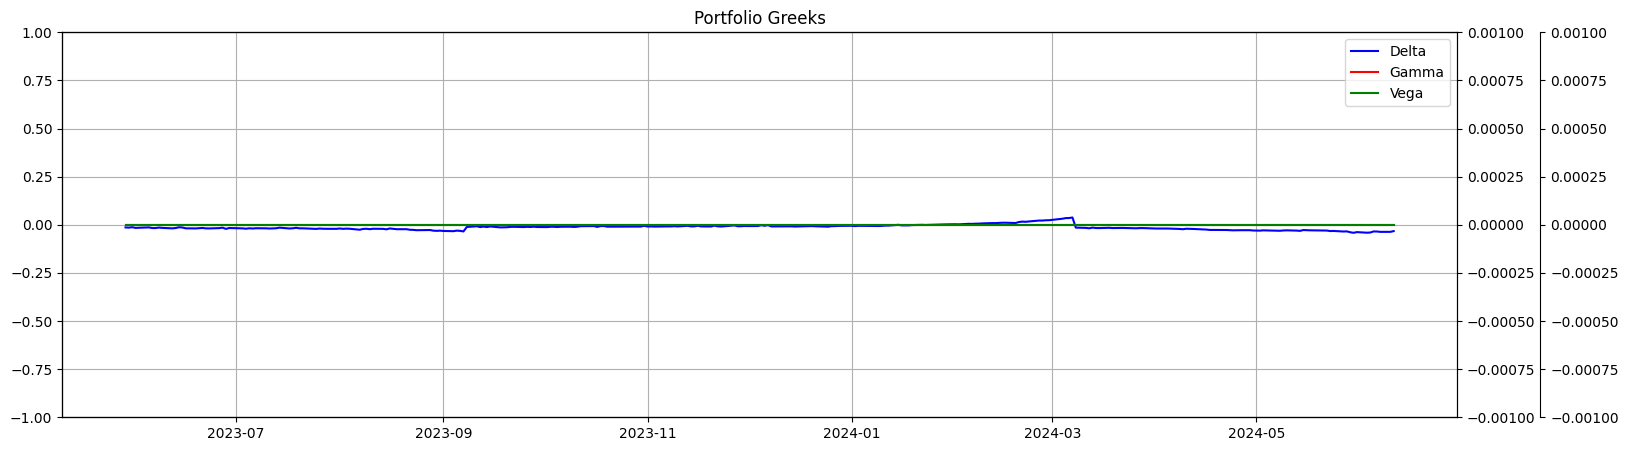

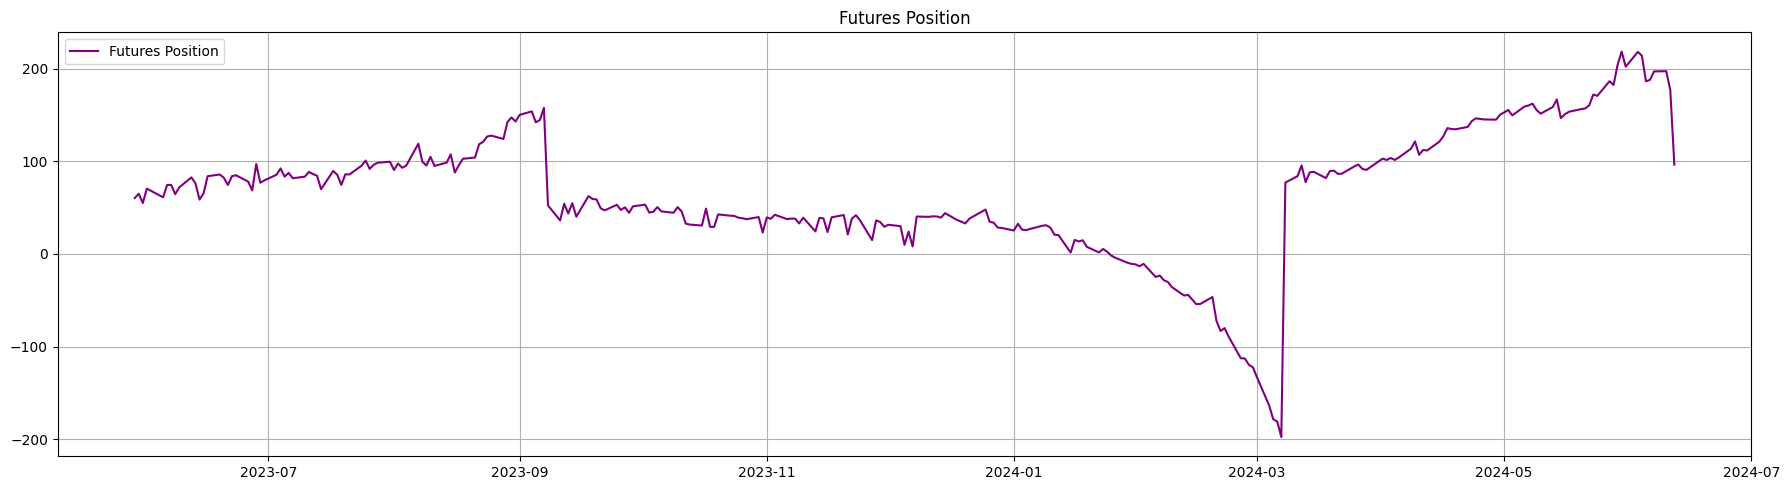

In [24]:
import matplotlib.pyplot as plt

# Set a cleaner style
plt.style.use("default")

# Create a function to apply consistent styling and generate subplots in groups
fig1, ax1 = plt.subplots(2, 2, figsize=(18, 10))
fig2, ax2 = plt.subplots(1, 2, figsize=(18, 5))
fig3, ax3 = plt.subplots(1, 1, figsize=(18, 5))
fig4, ax4 = plt.subplots(1, 1, figsize=(18, 5))

# Portfolio, Option, Other Options Value
ax1[0, 0].plot(results['total_portfolio_value'].iloc[:-7], label='Total Portfolio Value')
ax1[0, 0].set_title('Total Portfolio Value')
ax1[0, 0].legend()
ax1[0, 0].set_ylim([-1000, 1000])
ax1[0, 0].grid()

ax1[0, 1].plot(results['main_option_value'].iloc[:-7], label='Option Value')
ax1[0, 1].set_title('Main Option Value')
ax1[0, 1].legend()
ax1[0, 1].grid()

ax1[1, 0].plot(results['other_options_total_value'].iloc[:-7], label='Other Options Value')
ax1[1, 0].set_title('Other Options Value')
ax1[1, 0].legend()
ax1[1, 0].grid()

ax1[1, 1].plot(results['future_value'].iloc[:-1], label='Future Value')
ax1[1, 1].set_title('Future Value')
ax1[1, 1].legend()
ax1[1, 1].grid()

# Main Option Greeks
l1, = ax2[0].plot(greeks_option['delta'].iloc[:-7], label='Delta', color='blue')
ax2_right1 = ax2[0].twinx()
l2, = ax2_right1.plot(greeks_option['gamma'].iloc[:-7], label='Gamma', color='red')
ax2_right2 = ax2[0].twinx()
l3, = ax2_right2.plot(greeks_option['vega'].iloc[:-7], label='Vega', color='green')
ax2_right2.spines['right'].set_position(('outward', 60))
ax2[0].set_title('Main Option Greeks')
ax2[0].legend([l1, l2, l3], ['Delta', 'Gamma', 'Vega'])
ax2[0].grid()

# Other Option Greeks
l1, = ax2[1].plot(other_options_greeks['delta'].iloc[:-7], label='Delta', color='blue')
ax2r1 = ax2[1].twinx()
l2, = ax2r1.plot(other_options_greeks['gamma'].iloc[:-7], label='Gamma', color='red')
ax2r2 = ax2[1].twinx()
l3, = ax2r2.plot(other_options_greeks['vega'].iloc[:-7], label='Vega', color='green')
ax2r2.spines['right'].set_position(('outward', 60))
ax2[1].set_title('Other Option Greeks')
ax2[1].legend([l1, l2, l3], ['Delta', 'Gamma', 'Vega'])
ax2[1].grid()

# Portfolio Greeks and Futures Position
l1, = ax3.plot(portfolio_greeks['delta'].iloc[:-7], label='Delta', color='blue')
ax3r1 = ax3.twinx()
l2, = ax3r1.plot(portfolio_greeks['gamma'].iloc[:-7], label='Gamma', color='red')
ax3r1.set_ylim([-0.001, 0.001])
ax3r2 = ax3.twinx()
l3, = ax3r2.plot(portfolio_greeks['vega'].iloc[:-7], label='Vega', color='green')
ax3r2.set_ylim([-0.001, 0.001])
ax3r2.spines['right'].set_position(('outward', 60))
ax3.set_title('Portfolio Greeks')
ax3.legend([l1, l2, l3], ['Delta', 'Gamma', 'Vega'])
ax3.grid()
ax3.set_ylim([-1, 1])

ax4.plot(results['futures_position'].iloc[:-7], label='Futures Position', color='purple')
ax4.set_title('Futures Position')
ax4.legend()
ax4.grid()


fig1.savefig('../assets/MG_Portfolio.png')
fig2.savefig('../assets/MG_Greeks.png')
fig3.savefig('../assets/MG_TotalGreeks.png')
fig4.savefig('../assets/MG_Futures.png')
plt.tight_layout()
plt.show()
